# Install and load required libraries

In [ ]:
#!pip install miditok
#!pip install symusic
#!pip install glob
#!pip install torch

In [32]:
import glob
import random
from typing import List
from collections import defaultdict
from collections import Counter

import numpy as np
from numpy.random import choice
import math
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from symusic import Score
from miditok import REMI, TokenizerConfig
import miditoolkit
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi

# Task 1: Symbolic, unconditioned generation

# Exploratory Data Analysis

In [2]:
df = pd.read_csv("vgmidi_unlabelled.csv")
df.head()

,id,series,console,game,piece,midi,pdf
0,2932,Ace Attorney,Nintendo DS,Ace Attorney Investigations Miles Edgeworth,Kay Faraday The Great Truth Burglar,data_clean/midi/Ace Attorney_Nintendo DS_Ace A...,data_clean/pdf/Ace Attorney_Nintendo DS_Ace At...
1,4627,Ace Attorney,Nintendo DS,Ace Attorney Investigations Miles Edgeworth,Pursuit Lying Coldly,data_clean/midi/Ace Attorney_Nintendo DS_Ace A...,data_clean/pdf/Ace Attorney_Nintendo DS_Ace At...
2,4022,Ace Attorney,Nintendo DS,Apollo Justice Ace Attorney,Court Begins,data_clean/midi/Ace Attorney_Nintendo DS_Apoll...,data_clean/pdf/Ace Attorney_Nintendo DS_Apollo...
3,579,Ace Attorney,Nintendo DS,Apollo Justice Ace Attorney,Cross-Examination Moderato 2007,data_clean/midi/Ace Attorney_Nintendo DS_Apoll...,data_clean/pdf/Ace Attorney_Nintendo DS_Apollo...
4,2555,Ace Attorney,Nintendo DS,Apollo Justice Ace Attorney,Telling the Truth 2007,data_clean/midi/Ace Attorney_Nintendo DS_Apoll...,data_clean/pdf/Ace Attorney_Nintendo DS_Apollo...


In [3]:
all_files = np.array(df['midi'])

In [14]:
print("Number of MIDI files: ", len(all_files))
print("Example MIDI file: ", all_files[50])

Number of MIDI files:  3850
Example MIDI file:  data_clean/midi/Animal Crossing_Nintendo GameCube_Animal Crossing_Crazy Redds Black Market.mid


In [10]:
df.shape

(3850, 7)

In [ ]:
tracks = []
durations = []

for path in all_files:
    midi_data = pretty_midi.PrettyMIDI(path)

    tracks.append(len(midi_data.instruments))
    durations.append(midi_data.get_end_time())

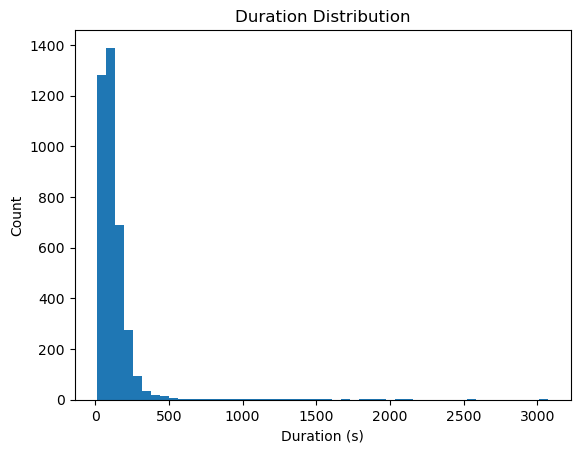

In [46]:
plt.hist(durations, bins=50)
plt.title("Duration Distribution")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

In [4]:
new_all_files = []
for path in all_files:
    midi_data = pretty_midi.PrettyMIDI(path)
    
    if midi_data.get_end_time() <= 300:
        new_all_files.append(path)

all_files = np.array(new_all_files)
print("Number of files after removing long MIDIs: ", len(all_files))

/home/k3liang/.local/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of files after removing long MIDIs:  3702


In [5]:
df = df[df["midi"].isin(all_files)]
df.shape

(3702, 7)

In [53]:
print("Number of franchises: ", len(np.unique(df['series'])))
print("Number of consoles: ", len(np.unique(df['console'])))
print("Number of games: ", len(np.unique(df['game'])))

Number of franchises:  45
Number of consoles:  37
Number of games:  721


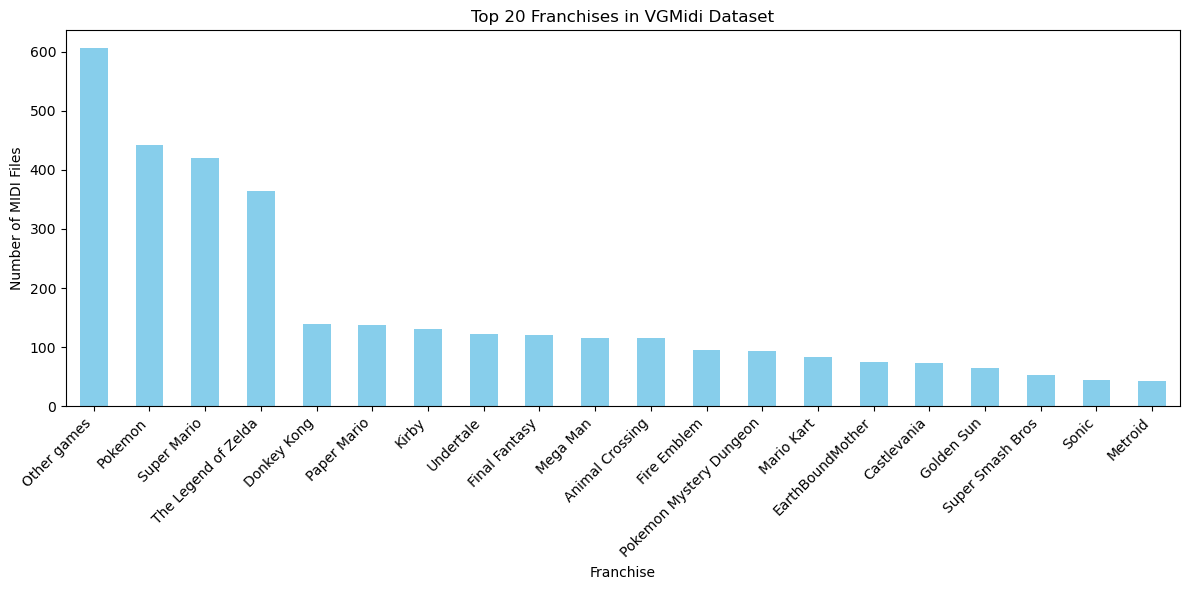

In [51]:
series_counts = df["series"].value_counts()

top_n = 20
series_counts.head(top_n).plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title(f"Top {top_n} Franchises in VGMidi Dataset")
plt.xlabel("Franchise")
plt.ylabel("Number of MIDI Files")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


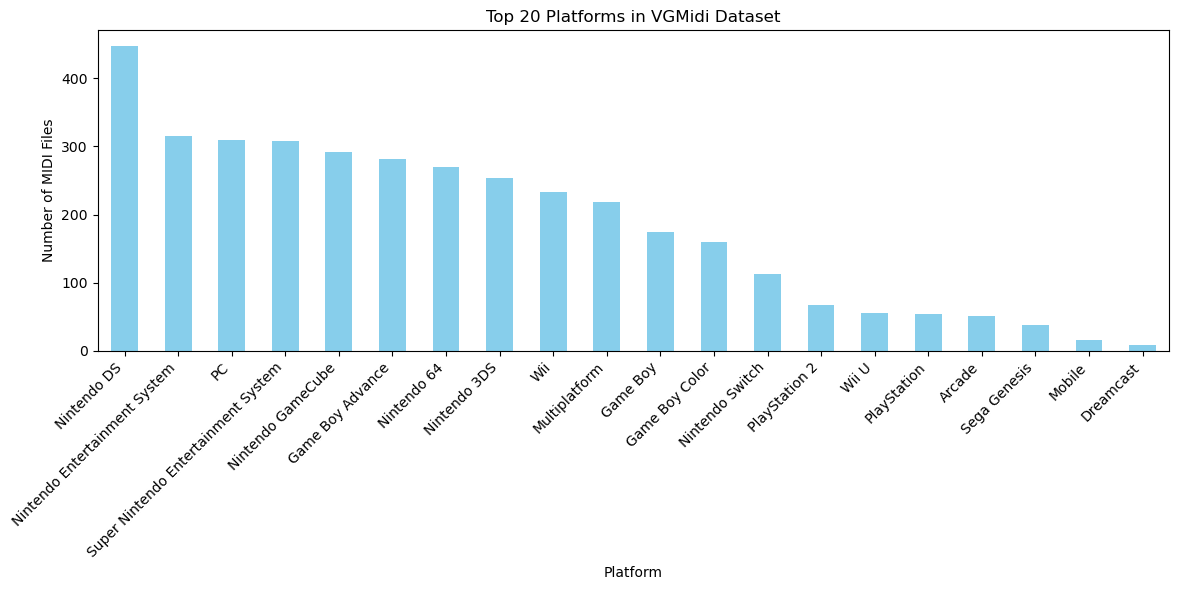

In [52]:
series_counts = df["console"].value_counts()

top_n = 20
series_counts.head(top_n).plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title(f"Top {top_n} Platforms in VGMidi Dataset")
plt.xlabel("Platform")
plt.ylabel("Number of MIDI Files")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
tracks = []
durations = []

for path in all_files:
    midi_data = pretty_midi.PrettyMIDI(path)

    tracks.append(len(midi_data.instruments))
    durations.append(midi_data.get_end_time())

In [14]:
print("Total Duration of MIDI files (hours): ", sum(durations) / 3600)

Total Duration of MIDI files (hours):  111.7153737507914


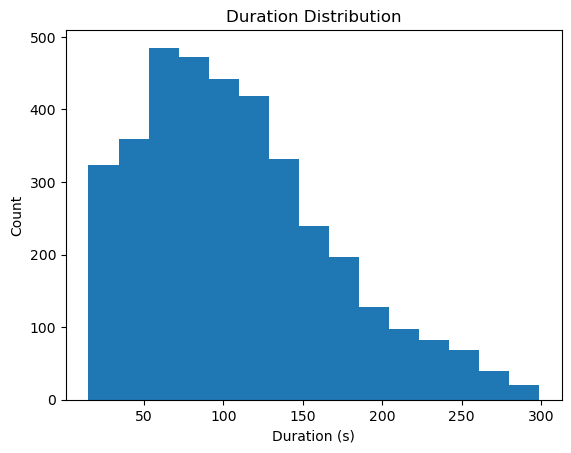

In [63]:
plt.hist(durations, bins=15)
plt.title("Duration Distribution")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

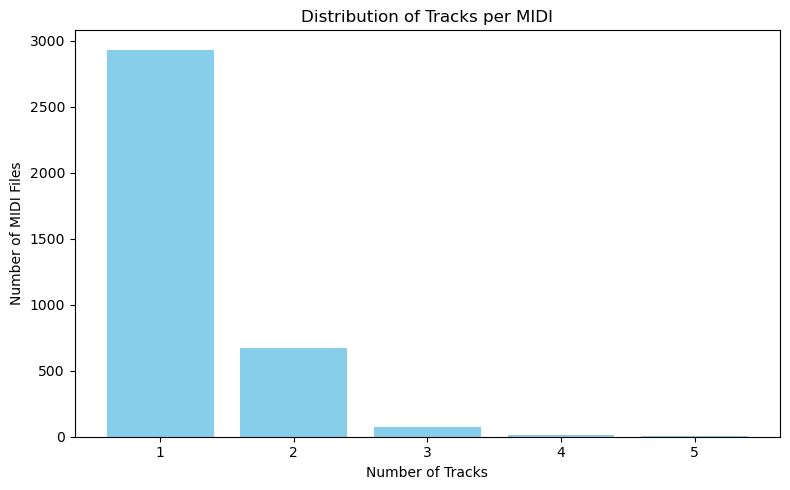

In [62]:
plt.figure(figsize=(8, 5))
plt.hist(tracks, bins=range(1, max(tracks)+2), align='left', rwidth=0.8, color='skyblue')
plt.xticks(range(1, max(tracks)+1))
plt.xlabel("Number of Tracks")
plt.ylabel("Number of MIDI Files")
plt.title("Distribution of Tracks per MIDI")
plt.tight_layout()
plt.show()

In [64]:
durations = []
note_densities = []
velocities = []
velocities_stds = []
tempos = []
pitches = []
pitch_stds = []
intervals = []

for path in all_files:
    midi = miditoolkit.MidiFile(path)
    ticks_per_beat = midi.ticks_per_beat
    notes = [note for inst in midi.instruments for note in inst.notes]
    
    if not notes:
        continue

    total_ticks = max(n.end for n in notes)
    tempo = 120
    avg_tempo = 0
    tempo_cnt = 0
    if midi.tempo_changes:
        tempo = midi.tempo_changes[0].tempo
        for temp in midi.tempo_changes:
            avg_tempo += temp.tempo
            tempo_cnt += 1
    avg_tempo = avg_tempo / tempo_cnt if tempo_cnt > 0 else 120
    total_sec = (total_ticks / ticks_per_beat) * (60 / avg_tempo)

    midi_pitches = [note.pitch for note in notes]
    midi_velocities = [note.velocity for note in notes]
    
    durations.append(total_sec)
    note_densities.append(len(notes) / total_sec)
    velocities.extend(midi_velocities)
    velocities_stds.append(np.std(midi_velocities))
    tempos.append(avg_tempo)
    pitches.extend(midi_pitches)
    pitch_stds.append(np.std(midi_pitches))

    midi_intervals = np.diff(midi_pitches)
    intervals.extend(midi_intervals)


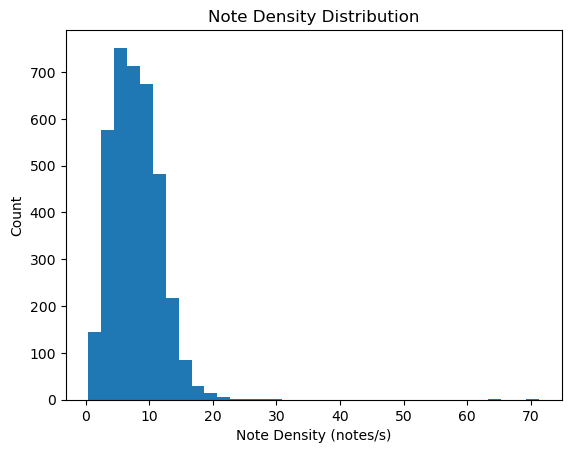

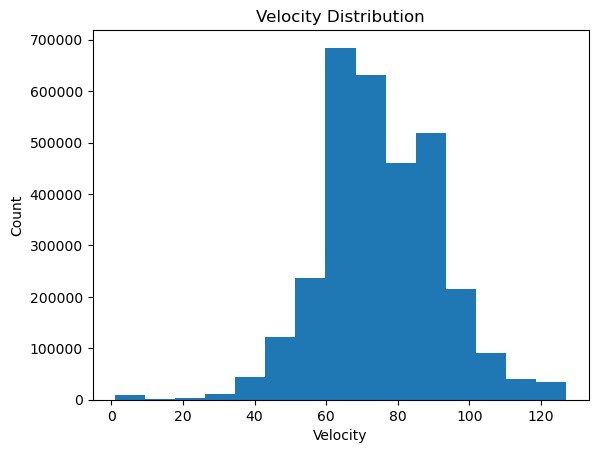

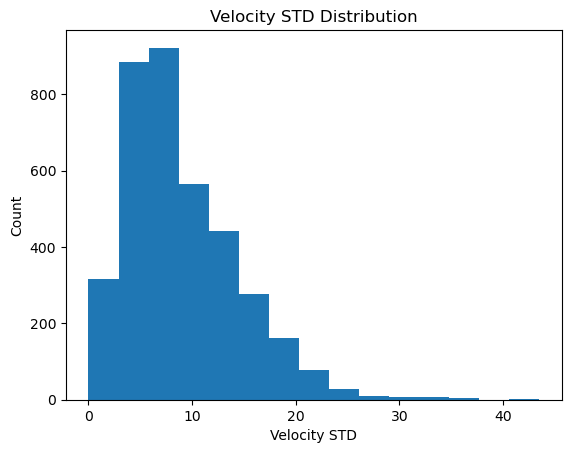

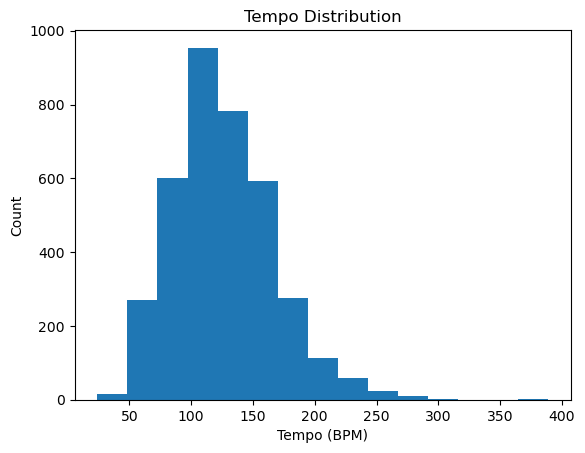

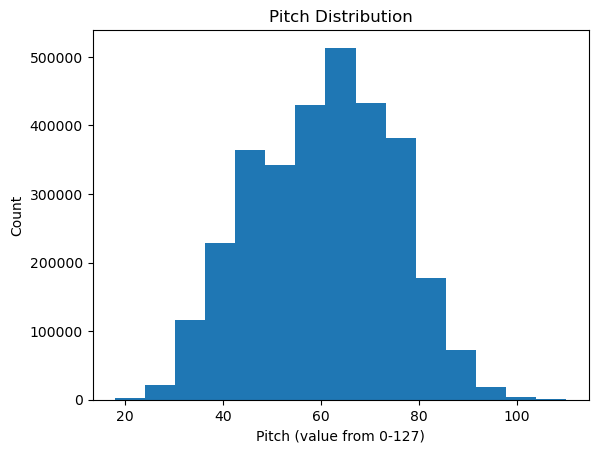

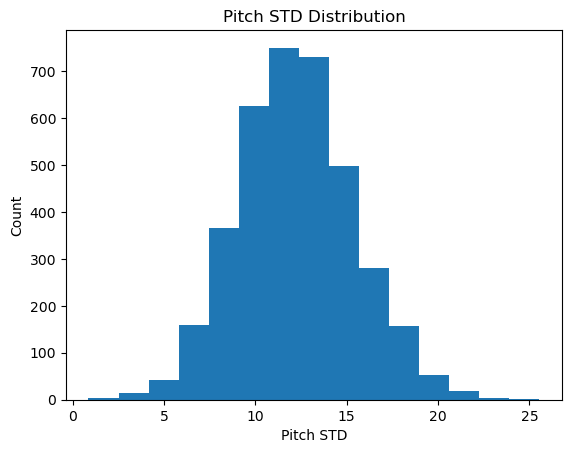

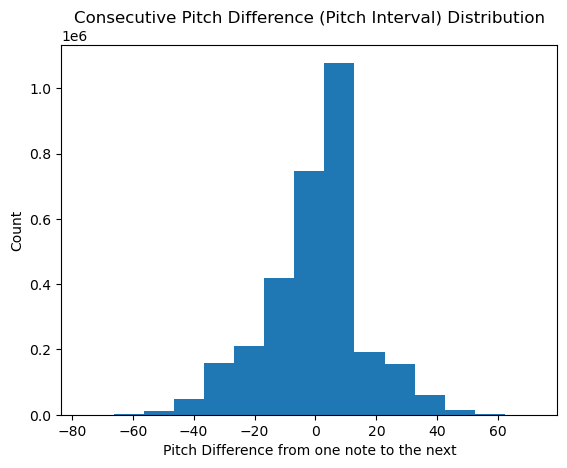

In [67]:
plt.hist(note_densities, bins=35)
plt.title("Note Density Distribution")
plt.xlabel("Note Density (notes/s)")
plt.ylabel("Count")
plt.show()

plt.hist(velocities, bins=15)
plt.title("Velocity Distribution")
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.show()

plt.hist(velocities_stds, bins=15)
plt.title("Velocity STD Distribution")
plt.xlabel("Velocity STD")
plt.ylabel("Count")
plt.show()

plt.hist(tempos, bins=15)
plt.title("Tempo Distribution")
plt.xlabel("Tempo (BPM)")
plt.ylabel("Count")
plt.show()

plt.hist(pitches, bins=15)
plt.title("Pitch Distribution")
plt.xlabel("Pitch (value from 0-127)")
plt.ylabel("Count")
plt.show()

plt.hist(pitch_stds, bins=15)
plt.title("Pitch STD Distribution")
plt.xlabel("Pitch STD")
plt.ylabel("Count")
plt.show()

plt.hist(intervals, bins=15)
plt.title("Consecutive Pitch Difference (Pitch Interval) Distribution")
plt.xlabel("Pitch Difference from one note to the next")
plt.ylabel("Count")
plt.show()

**Train-Validation-Test Split**  
80-10-10

In [6]:
np.random.seed(42)
np.random.shuffle(all_files)

total_len = len(all_files)
val_size = 0.1
test_size = 0.1

train_files = all_files[:-int(total_len*(test_size+val_size))]
val_files = all_files[-int(total_len*(test_size+val_size)):-int(total_len*test_size)]
test_files = all_files[-int(total_len*test_size):]

len(all_files), len(train_files), len(val_files), len(test_files)

(3702, 2962, 370, 370)

# Markov Chain (BASELINE)

## Train the MIDI tokenizer

In [ ]:
config = TokenizerConfig(num_velocities=1, use_chords=False, use_programs=True)
tokenizer = REMI(config)
tokenizer.train(vocab_size=1000, files_paths=train_files)
tokenizer.save("markovtokenizer.json")

/home/k3liang/.local/lib/python3.11/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [8]:
#tokenizer = REMI(params="markovtokenizer.json")

In [99]:
markov_tokenizer = tokenizer

## Construct a PyTorch Dataset

In [10]:
class MIDIDataset(Dataset):
    def __init__(self, file_paths: List[str], tokenizer):
        self.tokenizer = tokenizer
        self.file_paths = file_paths
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        midi = Score(self.file_paths[idx])
        tokens = self.tokenizer(midi)
        return np.array(tokens)

## Define PyTorch datasets and dataloaders

In [11]:
train_dataset = MIDIDataset(train_files, tokenizer)
val_dataset = MIDIDataset(val_files, tokenizer)
test_dataset = MIDIDataset(test_files, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Define a Second Order Markov Chain model

In [12]:
class SecondOrderMarkovChain:
    def __init__(self):
        self.transitions = defaultdict(lambda: defaultdict(int))
        self.probabilities = defaultdict(lambda: defaultdict(float))

    def train(self, train_loader):
        for sequence in train_loader:
            sequence = sequence[0].numpy().astype(int)
            for i in range(len(sequence) - 2):
                state1, state2 = sequence[i], sequence[i + 1]
                next_state = sequence[i + 2]
                self.transitions[(state1, state2)][next_state] += 1

        for (state1, state2), next_states in self.transitions.items():
            total = sum(next_states.values())
            for next_state, count in next_states.items():
                self.probabilities[(state1, state2)][next_state] = count / total
        return self.probabilities

    def generate(self, test_sequence, gen_length=100, num_predictions=1):
        test_sequence = test_sequence[0].numpy().astype(int)
        results = [test_sequence[0], test_sequence[1]]
        for i in range(gen_length):
            if (results[-2], results[-1]) not in self.probabilities:
                break
            else:
                probs = self.probabilities[(results[-2], results[-1])]
                states = list(probs.keys())
                probabilities = list(probs.values())
                if not states:
                    break
                try:
                    predictions = np.random.choice(states, size=num_predictions, p=probabilities)
                except:
                    break
                results.append(predictions[0])
        return results

## Train the model and make inferences

In [ ]:
model = SecondOrderMarkovChain()
model.train(train_loader)

In [98]:
predictions = []
for i, test_sequence in enumerate(test_loader):
    if i >= 500:
        break
    predictions.append(model.generate(test_sequence, gen_length=1000))
for i, prediction in enumerate(predictions):
    output_score = tokenizer.decode(torch.Tensor(prediction))
    output_score.dump_midi(f"markov/{i}.mid")

In [95]:
#!brew install wget
#!wget https://raw.githubusercontent.com/musescore/MuseScore/master/share/sound/FluidR3Mono_GM.sf3
#!pip install midi2audio
#!pip install IPython

In [ ]:
from midi2audio import FluidSynth # Import library
from IPython.display import Audio, display
fs = FluidSynth("FluidR3Mono_GM.sf3") # Initialize FluidSynth
for i in range(len(predictions)):
    fs.midi_to_audio(f"{i}.mid", f"{i}.wav")
    display(Audio(f"{i}.wav"))

## Evaluation of the Markov Model (Baseline)

In [66]:
def compute_markov_perplexity(markov_model, data_loader):
    log_prob_sum = 0
    token_count = 0

    for sequence in data_loader:
        sequence = sequence[0].numpy().astype(int)
        if len(sequence) < 3:
            continue

        for i in range(2, len(sequence)):
            state = (sequence[i-2], sequence[i-1])
            next_token = sequence[i]

            probs = markov_model.probabilities.get(state)
            if probs is None:
                continue  # skip unknown state

            prob = probs.get(next_token, 1e-8)  # small value to avoid log(0)
            log_prob_sum += math.log(prob)
            token_count += 1

    if token_count == 0:
        return float('inf') 

    perplexity = math.exp(-log_prob_sum / token_count)
    return perplexity




In [17]:
print("Markov Train Perplexity", compute_markov_perplexity(model, train_loader))

Markov Train Perplexity 13.172659238581225


In [18]:
print("Markov Validation Perplexity", compute_markov_perplexity(model, val_loader))

Markov Validation Perplexity 2023.3476095934257


In [19]:
print("Markov Test Perplexity", compute_markov_perplexity(model, test_loader))

Markov Test Perplexity 2040.7549596730541


# LSTM for MIDI generation

In [8]:
from miditok.pytorch_data import DatasetMIDI, DataCollator

In [45]:

tokenizer = REMI()  # using defaults parameters (constants.py)
train_dataset = DatasetMIDI(
    files_paths=train_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
val_dataset = DatasetMIDI(
    files_paths=val_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
test_dataset = DatasetMIDI(
    files_paths=test_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
collator = DataCollator(tokenizer.pad_token_id)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collator, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collator, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collator, num_workers=4)

In [46]:
len(train_loader), len(val_loader), len(test_loader)

(186, 24, 24)

## LSTM (with layer norm and dropout)

In [100]:
class MusicRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.3):
        super(MusicRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        out, hidden = self.rnn(x, hidden)  # out: (batch_size, seq_length, hidden_dim)
        out = self.norm(out)
        out = self.dropout(out)
        out = self.fc(out)  # (batch_size, seq_length, vocab_size)
        return out, hidden

### Training

In [ ]:
def train(model, train_loader, val_loader, vocab_size, num_epochs=20, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # --------- Training ---------
        model.train()
        total_train_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        #for batch in train_loader:
        for batch in pbar:
            batch = batch['input_ids'].to(device)  # (batch_size, seq_length)

            inputs = batch[:, :-1]
            targets = batch[:, 1:]

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)

        # --------- Validation ---------
        model.eval()
        total_val_loss = 0
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        
        with torch.no_grad():
            #for batch in val_loader:
            for batch in pbar:
                batch = batch['input_ids'].to(device)

                inputs = batch[:, :-1]
                targets = batch[:, 1:]

                outputs, _ = model(inputs)
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)

                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        avg_val_loss = total_val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_LSTM_model.pt")

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

#### Note that the "KeyboardInterrupt" errors are from me stopping the code, due to the validation loss plateauing

In [18]:
vocab_size = tokenizer.vocab_size
embedding_dim = 512
hidden_dim = 1024
num_layers = 2

model = MusicRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
train(model, train_loader, val_loader, vocab_size)

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.58it/s, loss=2.13]


Epoch 1/20 | Train Loss: 2.1240 | Val Loss: 1.7004


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.56it/s, loss=1.91]


Epoch 2/20 | Train Loss: 1.5620 | Val Loss: 1.5095


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.65it/s, loss=1.79]


Epoch 3/20 | Train Loss: 1.3790 | Val Loss: 1.3890


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.65it/s, loss=1.79]


Epoch 4/20 | Train Loss: 1.2515 | Val Loss: 1.3267


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.64it/s, loss=1.81]


Epoch 5/20 | Train Loss: 1.1432 | Val Loss: 1.2916


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s, loss=1.76]


Epoch 6/20 | Train Loss: 1.0577 | Val Loss: 1.2702


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.63it/s, loss=1.79]


Epoch 7/20 | Train Loss: 0.9691 | Val Loss: 1.2685


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s, loss=1.79]


Epoch 8/20 | Train Loss: 0.8890 | Val Loss: 1.2853


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.55it/s, loss=1.9] 


Epoch 9/20 | Train Loss: 0.8118 | Val Loss: 1.3109


Epoch 10/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.56it/s, loss=1.97]


Epoch 10/20 | Train Loss: 0.7357 | Val Loss: 1.3563


Epoch 11/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s, loss=1.92]


Epoch 11/20 | Train Loss: 0.6590 | Val Loss: 1.3941


Epoch 12/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.58it/s, loss=1.99]


Epoch 12/20 | Train Loss: 0.5922 | Val Loss: 1.4348


Epoch 13/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s, loss=2.1] 


Epoch 13/20 | Train Loss: 0.5307 | Val Loss: 1.5131


Epoch 14/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.58it/s, loss=2.29]


Epoch 14/20 | Train Loss: 0.4721 | Val Loss: 1.5812


Epoch 15/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.61it/s, loss=2.4] 


Epoch 15/20 | Train Loss: 0.4134 | Val Loss: 1.6686


Epoch 16/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.57it/s, loss=2.45]


Epoch 16/20 | Train Loss: 0.3693 | Val Loss: 1.7343


Epoch 17/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.61it/s, loss=2.58]


Epoch 17/20 | Train Loss: 0.3297 | Val Loss: 1.8310


Epoch 18/20 [Val]: 100%|██████████| 24/24 [00:09<00:00,  2.61it/s, loss=2.63]


Epoch 18/20 | Train Loss: 0.2959 | Val Loss: 1.8987


Epoch 19/20 [Train]:  26%|██▋       | 49/186 [00:30<01:25,  1.61it/s, loss=0.349]


KeyboardInterrupt: 

In [24]:
vocab_size = tokenizer.vocab_size
embedding_dim = vocab_size
hidden_dim = 768
num_layers = 2

model = MusicRNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.1)
train(model, train_loader, val_loader, vocab_size)

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  7.05it/s, loss=2.17]


Epoch 1/20 | Train Loss: 2.1274 | Val Loss: 1.7697


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.45it/s, loss=1.95]


Epoch 2/20 | Train Loss: 1.6192 | Val Loss: 1.5440


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s, loss=1.87]


Epoch 3/20 | Train Loss: 1.4302 | Val Loss: 1.4477


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  7.02it/s, loss=1.8] 


Epoch 4/20 | Train Loss: 1.3043 | Val Loss: 1.3607


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.67it/s, loss=1.8] 


Epoch 5/20 | Train Loss: 1.1989 | Val Loss: 1.3232


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.32it/s, loss=1.81]


Epoch 6/20 | Train Loss: 1.1101 | Val Loss: 1.2937


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s, loss=1.83]


Epoch 7/20 | Train Loss: 1.0352 | Val Loss: 1.2835


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.78it/s, loss=1.8] 


Epoch 8/20 | Train Loss: 0.9606 | Val Loss: 1.2891


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  7.26it/s, loss=1.86]


Epoch 9/20 | Train Loss: 0.8884 | Val Loss: 1.3082


Epoch 10/20 [Train]:   4%|▍         | 7/186 [00:02<00:56,  3.18it/s, loss=0.68] Exception ignored in: <function tqdm.__del__ at 0x7fe2bfd320c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

KeyboardInterrupt: 
Epoch 10/20 [Train]:   4%|▍         | 7/186 [00:03<01:28,  2.03it/s, loss=0.68]


KeyboardInterrupt: 

## LSTM (no dropout or layer norm)

In [47]:
class MusicRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(MusicRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        out, hidden = self.rnn(x, hidden)  # out: (batch_size, seq_length, hidden_dim)
        out = self.fc(out)  # (batch_size, seq_length, vocab_size)
        return out, hidden

In [20]:
vocab_size = tokenizer.vocab_size
embedding_dim = 256
hidden_dim = 512
num_layers = 2

model = MusicRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
train(model, train_loader, val_loader, vocab_size)

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.42it/s, loss=2.44]


Epoch 1/20 | Train Loss: 2.8894 | Val Loss: 2.1130


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.68it/s, loss=2.18]


Epoch 2/20 | Train Loss: 1.9225 | Val Loss: 1.8111


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  9.03it/s, loss=2.03]


Epoch 3/20 | Train Loss: 1.6980 | Val Loss: 1.6475


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.53it/s, loss=1.91]


Epoch 4/20 | Train Loss: 1.5337 | Val Loss: 1.5236


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.12it/s, loss=1.9] 


Epoch 5/20 | Train Loss: 1.4182 | Val Loss: 1.4526


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  9.73it/s, loss=1.84]


Epoch 6/20 | Train Loss: 1.3373 | Val Loss: 1.4030


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  7.79it/s, loss=1.79]


Epoch 7/20 | Train Loss: 1.2738 | Val Loss: 1.3595


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  9.18it/s, loss=1.76]


Epoch 8/20 | Train Loss: 1.2185 | Val Loss: 1.3366


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  9.12it/s, loss=1.73]


Epoch 9/20 | Train Loss: 1.1714 | Val Loss: 1.3178


Epoch 10/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.71it/s, loss=1.71]


Epoch 10/20 | Train Loss: 1.1246 | Val Loss: 1.3045


Epoch 11/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  9.49it/s, loss=1.75]


Epoch 11/20 | Train Loss: 1.0898 | Val Loss: 1.2937


Epoch 12/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  9.49it/s, loss=1.75]


Epoch 12/20 | Train Loss: 1.0512 | Val Loss: 1.2859


Epoch 13/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.55it/s, loss=1.8] 


Epoch 13/20 | Train Loss: 1.0123 | Val Loss: 1.2869


Epoch 14/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.41it/s, loss=1.77]


Epoch 14/20 | Train Loss: 0.9768 | Val Loss: 1.2904


Epoch 15/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.77it/s, loss=1.84]


Epoch 15/20 | Train Loss: 0.9460 | Val Loss: 1.2962


Epoch 16/20 [Val]: 100%|██████████| 24/24 [00:02<00:00,  8.25it/s, loss=1.85]


Epoch 16/20 | Train Loss: 0.9095 | Val Loss: 1.3018


Epoch 17/20 [Train]:  12%|█▏        | 22/186 [00:04<00:25,  6.54it/s, loss=0.892]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe5b2ed7b50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe5b2ed7b50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Epoch 17/20 [Train]:  12%|█▏        | 22/186 [00:04<00:35,  4.63it/s, loss=0.892]


KeyboardInterrupt: 

In [25]:
vocab_size = tokenizer.vocab_size
embedding_dim = vocab_size
hidden_dim = 768
num_layers = 2

model = MusicRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
train(model, train_loader, val_loader, vocab_size)

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.07it/s, loss=2.34]


Epoch 1/20 | Train Loss: 2.8404 | Val Loss: 2.0374


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.26it/s, loss=2.06]


Epoch 2/20 | Train Loss: 1.8542 | Val Loss: 1.7474


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.45it/s, loss=1.96]


Epoch 3/20 | Train Loss: 1.6149 | Val Loss: 1.5613


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.58it/s, loss=1.82]


Epoch 4/20 | Train Loss: 1.4414 | Val Loss: 1.4486


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.27it/s, loss=1.77]


Epoch 5/20 | Train Loss: 1.3312 | Val Loss: 1.3863


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.10it/s, loss=1.76]


Epoch 6/20 | Train Loss: 1.2505 | Val Loss: 1.3352


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.20it/s, loss=1.76]


Epoch 7/20 | Train Loss: 1.1788 | Val Loss: 1.3086


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.69it/s, loss=1.68]


Epoch 8/20 | Train Loss: 1.1218 | Val Loss: 1.2849


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.49it/s, loss=1.69]


Epoch 9/20 | Train Loss: 1.0612 | Val Loss: 1.2696


Epoch 10/20 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.94it/s, loss=1.73]


Epoch 10/20 | Train Loss: 1.0053 | Val Loss: 1.2656


Epoch 11/20 [Val]: 100%|██████████| 24/24 [00:04<00:00,  5.71it/s, loss=1.69]


Epoch 11/20 | Train Loss: 0.9518 | Val Loss: 1.2638


Epoch 12/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.05it/s, loss=1.75]


Epoch 12/20 | Train Loss: 0.8999 | Val Loss: 1.2725


Epoch 13/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.40it/s, loss=1.75]


Epoch 13/20 | Train Loss: 0.8492 | Val Loss: 1.2834


Epoch 14/20 [Val]: 100%|██████████| 24/24 [00:03<00:00,  6.46it/s, loss=1.73]


Epoch 14/20 | Train Loss: 0.7994 | Val Loss: 1.2945


Epoch 15/20 [Train]:   5%|▌         | 10/186 [00:03<00:49,  3.57it/s, loss=0.753]Exception ignored in: <function tqdm.__del__ at 0x7fe2bfd320c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

KeyboardInterrupt: 
Epoch 15/20 [Train]:   5%|▌         | 10/186 [00:03<01:09,  2.54it/s, loss=0.753]


KeyboardInterrupt: 

#### The above run has a plateau of validation loss of 1.2638, which is the best so far

### Load the best model

In [48]:
vocab_size = tokenizer.vocab_size
embedding_dim = vocab_size
hidden_dim = 768
num_layers = 2

model = MusicRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
model.load_state_dict(torch.load("best_LSTM_model.pt"))

<All keys matched successfully>

### Sampling

In [29]:
def sample(model, start_token, max_length=100, temperature=1.0, device='cuda'):
    model = model.to(device)
    model.eval()

    generated = [start_token]
    input_token = torch.tensor([[start_token]], device=device)  # (1, 1)

    hidden = None

    for _ in range(max_length):
        output, hidden = model(input_token, hidden)  # output: (1, 1, vocab_size)
        output = output[:, -1, :]  # take the last output
        output = output / temperature  # adjust randomness

        probs = F.softmax(output, dim=-1)  # (1, vocab_size)
        next_token = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_token)
        if next_token == 2 or next_token == 0: # reach end of sequence
          break

        input_token = torch.tensor([[next_token]], device=device)

    return generated

In [140]:
start_token = tokenizer.special_tokens_ids[1]
generated_sequence = sample(model, start_token, max_length=1024, temperature=0.8)

#print("Generated token sequence:")
print("Length of generated sequence: ", len(generated_sequence))
print("First 10 tokens: ", generated_sequence[:10])

Length of generated sequence:  1025
First 10 tokens:  [1, 4, 189, 60, 109, 132, 197, 65, 108, 128]


In [141]:
output_score = tokenizer.tokens_to_midi([generated_sequence])
output_score.dump_midi(f"lstm/rnn.mid")

/tmp/ipykernel_271/3546575264.py:1: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  output_score = tokenizer.tokens_to_midi([generated_sequence])


In [ ]:
from midi2audio import FluidSynth # Import library
from IPython.display import Audio, display
fs = FluidSynth("FluidR3Mono_GM.sf3") # Initialize FluidSynth

output_score = tokenizer.tokens_to_midi([generated_sequence])
output_score.dump_midi(f"rnn.mid")
fs.midi_to_audio("rnn.mid", "rnn.wav")
display(Audio("rnn.wav"))

#### Generating a lot of samples with the LSTM

In [145]:
for i in range(len(test_dataset)):
    start_token = tokenizer.special_tokens_ids[1]
    generated_sequence = sample(model, start_token, max_length=1024, temperature=0.8)

    output_score = tokenizer.tokens_to_midi([generated_sequence])
    output_score.dump_midi(f"lstm/{i}.mid")

/tmp/ipykernel_271/4026358655.py:5: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  output_score = tokenizer.tokens_to_midi([generated_sequence])


## Evaluation of LSTM

In [44]:
def compute_lstm_perplexity(model, test_loader, vocab_size, device='cuda'):
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='sum')
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating LSTM"):
            input_ids = batch['input_ids'].to(device)

            inputs = input_ids[:, :-1]
            targets = input_ids[:, 1:]

            outputs, _ = model(inputs)  # (batch_size, seq_len, vocab_size)
            logits = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            loss = criterion(logits, targets)
            total_loss += loss.item()
            total_tokens += (targets != tokenizer.pad_token_id).sum().item()

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    #print(f"LSTM Test Perplexity: {perplexity:.4f}")
    return perplexity


In [50]:
print("LSTM Train Perplexity", compute_lstm_perplexity(model, train_loader, vocab_size))

Evaluating LSTM: 100%|██████████| 186/186 [00:23<00:00,  8.05it/s]

LSTM Train Perplexity 2.5897968052260874


In [51]:
print("LSTM Validation Perplexity", compute_lstm_perplexity(model, val_loader, vocab_size))

Evaluating LSTM: 100%|██████████| 24/24 [00:04<00:00,  5.60it/s]

LSTM Validation Perplexity 3.8543762886927193


In [52]:
print("LSTM Test Perplexity", compute_lstm_perplexity(model, test_loader, vocab_size))

Evaluating LSTM: 100%|██████████| 24/24 [00:04<00:00,  5.67it/s]

LSTM Test Perplexity 3.7817340616269988


## Training a Transformer (from scratch)

In [147]:
tokenizer = REMI()
tokenizer.train(vocab_size=1000, files_paths=train_files) 
tokenizer.save("transformer_tokenizer.json")

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments

In [10]:
tokenizer = REMI(params="transformer_tokenizer.json")

In [11]:
train_dataset = DatasetMIDI(
    files_paths=train_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
val_dataset = DatasetMIDI(
    files_paths=val_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
test_dataset = DatasetMIDI(
    files_paths=test_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
collator = DataCollator(tokenizer.pad_token_id)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collator, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collator, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collator, num_workers=4)

In [12]:
vocab_size = len(tokenizer)

config = GPT2Config(
    vocab_size=vocab_size,
    n_positions=1024,
    n_embd=512,
    n_layer=8,
    n_head=8,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    pad_token_id=tokenizer["PAD_None"]
)

model = GPT2LMHeadModel(config)

In [13]:
def train(model, train_loader, val_loader, vocab_size, num_epochs=20, lr=5e-5, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["PAD_None"])
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # --------- Training ---------
        model.train()
        total_train_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        #for batch in train_loader:
        for batch in pbar:
            batch = batch['input_ids'].to(device)  # (batch_size, seq_length)

            inputs = batch[:, :-1]
            targets = batch[:, 1:]

            optimizer.zero_grad()
            #outputs, _ = model(inputs)
            outputs = model(inputs)
            logits = outputs.logits
            #outputs = outputs.reshape(-1, vocab_size)
            logits = logits.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            #loss = criterion(outputs, targets)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)

        # --------- Validation ---------
        model.eval()
        total_val_loss = 0
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        
        with torch.no_grad():
            #for batch in val_loader:
            for batch in pbar:
                batch = batch['input_ids'].to(device)

                inputs = batch[:, :-1]
                targets = batch[:, 1:]

                #outputs, _ = model(inputs)
                outputs = model(inputs)
                logits = outputs.logits
                #outputs = outputs.reshape(-1, vocab_size)
                logits = logits.reshape(-1, vocab_size)
                targets = targets.reshape(-1)

                #loss = criterion(outputs, targets)
                loss = criterion(logits, targets)
                total_val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        avg_val_loss = total_val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_transformer_model.pt")

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

In [10]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [168]:
vocab_size = tokenizer.vocab_size
train(model, train_loader, val_loader, vocab_size)

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.82it/s, loss=4.94]


Epoch 1/20 | Train Loss: 5.7664 | Val Loss: 5.0069


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s, loss=4.52]


Epoch 2/20 | Train Loss: 4.7413 | Val Loss: 4.4505


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.15it/s, loss=4.3] 


Epoch 3/20 | Train Loss: 4.3169 | Val Loss: 4.1505


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s, loss=4.16]


Epoch 4/20 | Train Loss: 4.0633 | Val Loss: 3.9729


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s, loss=4.05]


Epoch 5/20 | Train Loss: 3.8925 | Val Loss: 3.8445


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s, loss=3.99]


Epoch 6/20 | Train Loss: 3.7600 | Val Loss: 3.7386


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s, loss=3.92]


Epoch 7/20 | Train Loss: 3.6457 | Val Loss: 3.6491


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s, loss=3.82]


Epoch 8/20 | Train Loss: 3.5410 | Val Loss: 3.5638


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.84it/s, loss=3.75]


Epoch 9/20 | Train Loss: 3.4390 | Val Loss: 3.4609


Epoch 10/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.90it/s, loss=3.71]


Epoch 10/20 | Train Loss: 3.3337 | Val Loss: 3.3426


Epoch 11/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s, loss=3.57]


Epoch 11/20 | Train Loss: 3.2176 | Val Loss: 3.2225


Epoch 12/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.10it/s, loss=3.46]


Epoch 12/20 | Train Loss: 3.0876 | Val Loss: 3.0693


Epoch 13/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s, loss=3.28]


Epoch 13/20 | Train Loss: 2.9554 | Val Loss: 2.9182


Epoch 14/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s, loss=3.05]


Epoch 14/20 | Train Loss: 2.8145 | Val Loss: 2.7529


Epoch 15/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s, loss=2.91]


Epoch 15/20 | Train Loss: 2.6800 | Val Loss: 2.6142


Epoch 16/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s, loss=2.71]


Epoch 16/20 | Train Loss: 2.5386 | Val Loss: 2.4706


Epoch 17/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s, loss=2.55]


Epoch 17/20 | Train Loss: 2.4153 | Val Loss: 2.3364


Epoch 18/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s, loss=2.33]


Epoch 18/20 | Train Loss: 2.2972 | Val Loss: 2.2262


Epoch 19/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s, loss=2.17]


Epoch 19/20 | Train Loss: 2.1881 | Val Loss: 2.1255


Epoch 20/20 [Val]: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s, loss=2.03]


Epoch 20/20 | Train Loss: 2.0971 | Val Loss: 2.0097


In [ ]:
train(model, train_loader, val_loader, vocab_size, num_epochs=10)

Epoch 1/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s, loss=1.97]


Epoch 1/10 | Train Loss: 1.9978 | Val Loss: 1.9415


Epoch 2/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.94it/s, loss=1.84]


Epoch 2/10 | Train Loss: 1.9133 | Val Loss: 1.8503


Epoch 3/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s, loss=1.76]


Epoch 3/10 | Train Loss: 1.8359 | Val Loss: 1.7856


Epoch 4/10 [Train]:  56%|█████▌    | 104/186 [01:16<00:58,  1.40it/s, loss=1.89]

In [16]:
train(model, train_loader, val_loader, vocab_size, num_epochs=10)

Epoch 1/10 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.14it/s, loss=1.65]


Epoch 1/10 | Train Loss: 1.7138 | Val Loss: 1.6768


Epoch 2/10 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s, loss=1.6] 


Epoch 2/10 | Train Loss: 1.6495 | Val Loss: 1.6430


Epoch 3/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s, loss=1.56]


Epoch 3/10 | Train Loss: 1.5981 | Val Loss: 1.5965


Epoch 4/10 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s, loss=1.54]


Epoch 4/10 | Train Loss: 1.5631 | Val Loss: 1.5553


Epoch 5/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s, loss=1.52]


Epoch 5/10 | Train Loss: 1.5094 | Val Loss: 1.5391


Epoch 6/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s, loss=1.5] 


Epoch 6/10 | Train Loss: 1.4771 | Val Loss: 1.5142


Epoch 7/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s, loss=1.48]


Epoch 7/10 | Train Loss: 1.4370 | Val Loss: 1.4948


Epoch 8/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s, loss=1.47]


Epoch 8/10 | Train Loss: 1.4019 | Val Loss: 1.4872


Epoch 9/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.91it/s, loss=1.46]


Epoch 9/10 | Train Loss: 1.3727 | Val Loss: 1.4627


Epoch 10/10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.86it/s, loss=1.47]


Epoch 10/10 | Train Loss: 1.3442 | Val Loss: 1.4611


In [17]:
train(model, train_loader, val_loader, vocab_size, num_epochs=50, lr=1e-5)

Epoch 1/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.13it/s, loss=1.42]


Epoch 1/50 | Train Loss: 1.2642 | Val Loss: 1.4252


Epoch 2/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s, loss=1.42]


Epoch 2/50 | Train Loss: 1.2462 | Val Loss: 1.4210


Epoch 3/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s, loss=1.41]


Epoch 3/50 | Train Loss: 1.2367 | Val Loss: 1.4174


Epoch 4/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.12it/s, loss=1.42]


Epoch 4/50 | Train Loss: 1.2315 | Val Loss: 1.4163


Epoch 5/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.19it/s, loss=1.42]


Epoch 5/50 | Train Loss: 1.2241 | Val Loss: 1.4107


Epoch 6/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s, loss=1.42]


Epoch 6/50 | Train Loss: 1.2133 | Val Loss: 1.4138


Epoch 7/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s, loss=1.41]


Epoch 7/50 | Train Loss: 1.2056 | Val Loss: 1.4111


Epoch 8/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.10it/s, loss=1.42]


Epoch 8/50 | Train Loss: 1.1987 | Val Loss: 1.4116


Epoch 9/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.90it/s, loss=1.42]


Epoch 9/50 | Train Loss: 1.1917 | Val Loss: 1.4142


Epoch 10/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s, loss=1.42]


Epoch 10/50 | Train Loss: 1.1832 | Val Loss: 1.4105


Epoch 11/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s, loss=1.43]


Epoch 11/50 | Train Loss: 1.1784 | Val Loss: 1.4182


Epoch 12/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.15it/s, loss=1.42]


Epoch 12/50 | Train Loss: 1.1721 | Val Loss: 1.4147


Epoch 13/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s, loss=1.42]


Epoch 13/50 | Train Loss: 1.1630 | Val Loss: 1.4172


Epoch 14/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s, loss=1.42]


Epoch 14/50 | Train Loss: 1.1607 | Val Loss: 1.4035


Epoch 15/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.17it/s, loss=1.42]


Epoch 15/50 | Train Loss: 1.1530 | Val Loss: 1.4123


Epoch 16/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.17it/s, loss=1.42]


Epoch 16/50 | Train Loss: 1.1442 | Val Loss: 1.4110


Epoch 17/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s, loss=1.41]


Epoch 17/50 | Train Loss: 1.1394 | Val Loss: 1.4117


Epoch 18/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s, loss=1.43]


Epoch 18/50 | Train Loss: 1.1323 | Val Loss: 1.4066


Epoch 19/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.16it/s, loss=1.43]


Epoch 19/50 | Train Loss: 1.1288 | Val Loss: 1.4081


Epoch 20/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s, loss=1.41]


Epoch 20/50 | Train Loss: 1.1236 | Val Loss: 1.4067


Epoch 21/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.12it/s, loss=1.43]


Epoch 21/50 | Train Loss: 1.1169 | Val Loss: 1.4115


Epoch 22/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s, loss=1.43]


Epoch 22/50 | Train Loss: 1.1130 | Val Loss: 1.4127


Epoch 23/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s, loss=1.42]


Epoch 23/50 | Train Loss: 1.1040 | Val Loss: 1.4104


Epoch 24/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.23it/s, loss=1.43]


Epoch 24/50 | Train Loss: 1.0976 | Val Loss: 1.4136


Epoch 25/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s, loss=1.43]


Epoch 25/50 | Train Loss: 1.0939 | Val Loss: 1.4150


Epoch 26/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.11it/s, loss=1.44]


Epoch 26/50 | Train Loss: 1.0901 | Val Loss: 1.4139


Epoch 27/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.17it/s, loss=1.43]


Epoch 27/50 | Train Loss: 1.0797 | Val Loss: 1.4171


Epoch 28/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.89it/s, loss=1.44]


Epoch 28/50 | Train Loss: 1.0743 | Val Loss: 1.4130


Epoch 29/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s, loss=1.44]


Epoch 29/50 | Train Loss: 1.0710 | Val Loss: 1.4157


Epoch 30/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s, loss=1.43]


Epoch 30/50 | Train Loss: 1.0655 | Val Loss: 1.4120


Epoch 31/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.18it/s, loss=1.44]


Epoch 31/50 | Train Loss: 1.0578 | Val Loss: 1.4175


Epoch 32/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.14it/s, loss=1.44]


Epoch 32/50 | Train Loss: 1.0526 | Val Loss: 1.4204


Epoch 33/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.00it/s, loss=1.45]


Epoch 33/50 | Train Loss: 1.0477 | Val Loss: 1.4286


Epoch 34/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s, loss=1.44]


Epoch 34/50 | Train Loss: 1.0419 | Val Loss: 1.4160


Epoch 35/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.19it/s, loss=1.44]


Epoch 35/50 | Train Loss: 1.0403 | Val Loss: 1.4224


Epoch 36/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.13it/s, loss=1.46]


Epoch 36/50 | Train Loss: 1.0327 | Val Loss: 1.4277


Epoch 37/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.13it/s, loss=1.47]


Epoch 37/50 | Train Loss: 1.0297 | Val Loss: 1.4285


Epoch 38/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s, loss=1.46]


Epoch 38/50 | Train Loss: 1.0212 | Val Loss: 1.4240


Epoch 39/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s, loss=1.45]


Epoch 39/50 | Train Loss: 1.0200 | Val Loss: 1.4212


Epoch 40/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s, loss=1.46]


Epoch 40/50 | Train Loss: 1.0108 | Val Loss: 1.4300


Epoch 41/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s, loss=1.46]


Epoch 41/50 | Train Loss: 1.0080 | Val Loss: 1.4262


Epoch 42/50 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.81it/s, loss=1.47]


Epoch 42/50 | Train Loss: 0.9996 | Val Loss: 1.4313


Epoch 43/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.18it/s, loss=1.46]


Epoch 43/50 | Train Loss: 0.9987 | Val Loss: 1.4305


Epoch 44/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.21it/s, loss=1.46]


Epoch 44/50 | Train Loss: 0.9891 | Val Loss: 1.4309


Epoch 45/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.14it/s, loss=1.48]


Epoch 45/50 | Train Loss: 0.9861 | Val Loss: 1.4416


Epoch 46/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.22it/s, loss=1.47]


Epoch 46/50 | Train Loss: 0.9792 | Val Loss: 1.4426


Epoch 47/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.18it/s, loss=1.47]


Epoch 47/50 | Train Loss: 0.9764 | Val Loss: 1.4390


Epoch 48/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s, loss=1.47]


Epoch 48/50 | Train Loss: 0.9699 | Val Loss: 1.4458


Epoch 49/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.15it/s, loss=1.47]


Epoch 49/50 | Train Loss: 0.9667 | Val Loss: 1.4422


Epoch 50/50 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.23it/s, loss=1.48]

Epoch 50/50 | Train Loss: 0.9607 | Val Loss: 1.4525


### The above run wasn't good. Let's make the tokenizer have default settings, and learning rate should increase.

In [11]:

tokenizer = REMI()  # using defaults parameters (constants.py)
train_dataset = DatasetMIDI(
    files_paths=train_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
val_dataset = DatasetMIDI(
    files_paths=val_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
test_dataset = DatasetMIDI(
    files_paths=test_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)
collator = DataCollator(tokenizer.pad_token_id)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collator, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collator, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collator, num_workers=4)

vocab_size = len(tokenizer)

config = GPT2Config(
    vocab_size=vocab_size,
    n_positions=1024,
    n_embd=512,
    n_layer=8,
    n_head=8,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    pad_token_id=tokenizer["PAD_None"]
)

model = GPT2LMHeadModel(config)

In [42]:
vocab_size = tokenizer.vocab_size
train(model, train_loader, val_loader, vocab_size, lr=1e-3)

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.49it/s, loss=2.75]


Epoch 1/20 | Train Loss: 3.0979 | Val Loss: 2.6663


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.39it/s, loss=2.63]


Epoch 2/20 | Train Loss: 2.5471 | Val Loss: 2.4509


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s, loss=2.58]


Epoch 3/20 | Train Loss: 2.3758 | Val Loss: 2.3310


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s, loss=2.5] 


Epoch 4/20 | Train Loss: 2.2744 | Val Loss: 2.2504


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s, loss=2.18]


Epoch 5/20 | Train Loss: 2.0680 | Val Loss: 1.9234


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s, loss=2.02]


Epoch 6/20 | Train Loss: 1.8559 | Val Loss: 1.8143


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s, loss=2]   


Epoch 7/20 | Train Loss: 1.7666 | Val Loss: 1.7549


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s, loss=1.91]


Epoch 8/20 | Train Loss: 1.7070 | Val Loss: 1.6964


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s, loss=1.91]


Epoch 9/20 | Train Loss: 1.6597 | Val Loss: 1.6295


Epoch 10/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s, loss=1.82]


Epoch 10/20 | Train Loss: 1.6072 | Val Loss: 1.5838


Epoch 11/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s, loss=1.7] 


Epoch 11/20 | Train Loss: 1.5445 | Val Loss: 1.5020


Epoch 12/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.40it/s, loss=1.65]


Epoch 12/20 | Train Loss: 1.4745 | Val Loss: 1.4189


Epoch 13/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.42it/s, loss=1.54]


Epoch 13/20 | Train Loss: 1.3908 | Val Loss: 1.3245


Epoch 14/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.50it/s, loss=1.43]


Epoch 14/20 | Train Loss: 1.3098 | Val Loss: 1.2255


Epoch 15/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s, loss=1.3] 


Epoch 15/20 | Train Loss: 1.2261 | Val Loss: 1.1531


Epoch 16/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.31it/s, loss=1.24] 


Epoch 16/20 | Train Loss: 1.1528 | Val Loss: 1.0929


Epoch 17/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.16it/s, loss=1.2]  


Epoch 17/20 | Train Loss: 1.0963 | Val Loss: 1.0314


Epoch 18/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.43it/s, loss=1.14] 


Epoch 18/20 | Train Loss: 1.0308 | Val Loss: 0.9887


Epoch 19/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.50it/s, loss=1.11] 


Epoch 19/20 | Train Loss: 0.9794 | Val Loss: 0.9487


Epoch 20/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s, loss=1.07] 


Epoch 20/20 | Train Loss: 0.9306 | Val Loss: 0.9280


In [43]:
train(model, train_loader, val_loader, vocab_size, lr=1e-3)

Epoch 1/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s, loss=1.06] 


Epoch 1/20 | Train Loss: 0.9086 | Val Loss: 0.8915


Epoch 2/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s, loss=1.02] 


Epoch 2/20 | Train Loss: 0.8648 | Val Loss: 0.8798


Epoch 3/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s, loss=1.03] 


Epoch 3/20 | Train Loss: 0.8276 | Val Loss: 0.8549


Epoch 4/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.47it/s, loss=1.02] 


Epoch 4/20 | Train Loss: 0.7969 | Val Loss: 0.8447


Epoch 5/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.48it/s, loss=0.992]


Epoch 5/20 | Train Loss: 0.7683 | Val Loss: 0.8354


Epoch 6/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.21it/s, loss=0.991]


Epoch 6/20 | Train Loss: 0.7459 | Val Loss: 0.8166


Epoch 7/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s, loss=0.999]


Epoch 7/20 | Train Loss: 0.7208 | Val Loss: 0.8155


Epoch 8/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s, loss=0.975]


Epoch 8/20 | Train Loss: 0.6946 | Val Loss: 0.8087


Epoch 9/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s, loss=0.977]


Epoch 9/20 | Train Loss: 0.6693 | Val Loss: 0.8110


Epoch 10/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s, loss=0.988]


Epoch 10/20 | Train Loss: 0.6563 | Val Loss: 0.8140


Epoch 11/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.18it/s, loss=0.97] 


Epoch 11/20 | Train Loss: 0.6367 | Val Loss: 0.7977


Epoch 12/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.39it/s, loss=0.965]


Epoch 12/20 | Train Loss: 0.6143 | Val Loss: 0.8087


Epoch 13/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.52it/s, loss=1.02] 


Epoch 13/20 | Train Loss: 0.5914 | Val Loss: 0.8192


Epoch 14/20 [Val]: 100%|██████████| 24/24 [00:05<00:00,  4.19it/s, loss=0.986]


Epoch 14/20 | Train Loss: 0.5758 | Val Loss: 0.8125


Epoch 15/20 [Train]:  13%|█▎        | 25/186 [00:19<02:05,  1.29it/s, loss=0.61] 


KeyboardInterrupt: 

In [33]:
vocab_size = len(tokenizer)

config = GPT2Config(
    vocab_size=vocab_size,
    n_positions=1024,
    n_embd=512,
    n_layer=8,
    n_head=8,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    pad_token_id=tokenizer["PAD_None"]
)

model = GPT2LMHeadModel(config)

In [12]:
model.load_state_dict(torch.load("best_transformer_model.pt"))

<All keys matched successfully>

In [32]:
model.eval().to("cuda")

for i in range(len(test_dataset)):

    # Prepare generation input
    bos_token = tokenizer["BOS_None"]
    input_ids = torch.tensor([[bos_token]], device="cuda")  # shape: (1, 1)
    
    # Generate tokens
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            max_length=1024,
            do_sample=True,
            temperature=1.11,
            top_k=50,
            top_p=0.95,
            eos_token_id=tokenizer["EOS_None"],
            pad_token_id=tokenizer["PAD_None"],
        )
    
    # Decode back to MIDI
    tokens = generated_ids[0].tolist()
    midi_obj = tokenizer.tokens_to_midi([tokens])
    #midi_obj.dump_midi("generated_sample.mid")
    midi_obj.dump_midi(f"transformer/{i}.mid")


/tmp/ipykernel_269/2442309378.py:24: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  midi_obj = tokenizer.tokens_to_midi([tokens])


## Evaluation of Transformer

In [39]:
def compute_perplexity(model, test_loader, device='cuda'):
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='sum')  # sum to compute avg later
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)

            inputs = input_ids[:, :-1]        # shift inputs
            targets = input_ids[:, 1:]        # shift targets

            outputs = model(inputs)
            logits = outputs.logits           # (batch_size, seq_len, vocab_size)

            logits = logits.reshape(-1, logits.size(-1))
            targets = targets.reshape(-1)

            loss = criterion(logits, targets)
            total_loss += loss.item()
            total_tokens += (targets != tokenizer.pad_token_id).sum().item()

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    #print(f"Perplexity: {perplexity:.4f}")
    return perplexity


In [41]:
print("Transformer Train Perplexity", compute_perplexity(model, train_loader))

Evaluating: 100%|██████████| 186/186 [00:37<00:00,  4.99it/s]

Transformer Train Perplexity 1.6511208143361296


In [42]:
print("Transformer Validation Perplexity", compute_perplexity(model, val_loader))

Evaluating: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s]

Transformer Validation Perplexity 2.2039724552282984


In [40]:
print("Transformer Test Perplexity", compute_perplexity(model, test_loader))

Evaluating: 100%|██████████| 24/24 [00:05<00:00,  4.13it/s]

Transformer Test Perplexity 2.203942218495373


## Evaluation of all models based on Maximum Mean Discrepancy

In [47]:
def features(path):
    midi_obj = miditoolkit.MidiFile(path)
    ticks_per_beat = midi_obj.ticks_per_beat
    notes = [n for inst in midi_obj.instruments for n in inst.notes if not inst.is_drum]

    if len(notes) <= 1:
        return None
    
    max_tick = max(n.end for n in notes)

    # Pitch features (6)
    pitches = np.array([n.pitch for n in notes])
    mean_pitch = np.mean(pitches)
    pitch_std = np.std(pitches)
    max_pitch = np.max(pitches)
    min_pitch = np.min(pitches)
    pitch_range = max_pitch - min_pitch
    pitch_entropy = stats.entropy(np.bincount(pitches) / len(pitches))
    pitch_range_90 = max_pitch - np.percentile(pitches, 90)
    pitch_range_10 = np.percentile(pitches, 10) - min_pitch

    durations = np.array([(n.end - n.start) / ticks_per_beat for n in notes])
    mean_duration = np.mean(durations)
    duration_std = np.std(durations)

    # 3. Pitch class histogram (12D)
    pitch_classes = pitches % 12
    histogram = np.zeros(12)
    counts = Counter(pitch_classes)
    for pc in counts:
        histogram[pc] = counts[pc]
    pitch_class_histogram = histogram / len(pitches)  # Normalize

    intervals = np.diff(pitches)
    mean_interval = np.mean(intervals)
    std_interval = np.std(intervals)
    interval_hist = np.histogram(intervals, bins=np.arange(-12.5, 13.5, 2))[0]
    interval_hist = interval_hist / np.sum(interval_hist) if np.sum(interval_hist) else interval_hist
    interval_hist = interval_hist.tolist()
    
    #short_thresh = ticks_per_beat / 4
    #pct_short_notes = np.sum(durations < short_thresh) / len(durations)
    total_ticks = max(n.end for n in notes)
    tempo = 120
    avg_tempo = 0
    tempo_cnt = 0
    if midi_obj.tempo_changes:
        tempo = midi_obj.tempo_changes[0].tempo
        for temp in midi_obj.tempo_changes:
            #avg_tempo += 60000000 / temp.tempo
            avg_tempo += temp.tempo
            tempo_cnt += 1
    avg_tempo = avg_tempo / tempo_cnt if tempo_cnt > 0 else 120
    total_sec = (total_ticks / ticks_per_beat) * (60 / avg_tempo)


    # Polyphony/Texture features (5)
    concurrent = np.zeros(total_ticks + 1)
    for n in notes:
        concurrent[n.start:n.end] += 1
    poly_active = concurrent[concurrent > 0]
    avg_polyphony = np.mean(poly_active)
    max_polyphony = np.max(poly_active)
    monophonic_ratio = np.sum(poly_active == 1) / len(poly_active)
    polyphony_std = np.std(poly_active)
    pct_time_polyphonic = np.sum(poly_active >= 3) / len(poly_active)
    

    # Metadata/Time Signature/Tempo (8)
    time_sig = (4, 4)
    if midi_obj.time_signature_changes:
        ts = midi_obj.time_signature_changes[0]
        time_sig = (ts.numerator, ts.denominator)
    time_sig_onehot = [0, 0, 0, 0]  # 4/4, 3/4, other
    if time_sig == (4, 4):
        time_sig_onehot[0] = 1
    elif time_sig == (3, 4):
        time_sig_onehot[1] = 1
    elif time_sig == (2, 4):
        time_sig_onehot[2] = 1
    else:
        time_sig_onehot[3] = 1

    unique_pitches = len(set(pitches))
    
    velocities = [note.velocity for note in notes]
    avg_velocity = np.mean(velocities)
    velocity_std = np.std(velocities)
    max_velocity = np.max(velocities)
    min_velocity = np.min(velocities)
    velocity_range = max_velocity - min_velocity

    # crude heuristic: look at minor vs major thirds
    third_intervals = [abs(n2.pitch - n1.pitch) for n1, n2 in zip(notes[:-1], notes[1:])]
    minor_thirds = sum(1 for i in third_intervals if i == 3)
    major_thirds = sum(1 for i in third_intervals if i == 4)
    mode_flag = 1 if major_thirds >= minor_thirds else 0  # 1 = major, 0 = minor

    
    #keysig [0,5,8,10
    key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else -1
    key_sig_onehot = [0]*5
    if key_signature == 0:
        key_sig_onehot[0] = 1
    elif key_signature == 5:
        key_sig_onehot[1] = 1
    elif key_signature == 8:
        key_sig_onehot[2] = 1
    elif key_signature == 10:
        key_sig_onehot[3] = 1
    else:
        key_sig_onehot[4] = 1

    
    return [
        pitch_std, pitch_range, pitch_entropy, unique_pitches,
        *pitch_class_histogram[0:3],*pitch_class_histogram[7:9],
        *interval_hist[1:6], *interval_hist[7:9],
        avg_polyphony, max_polyphony, monophonic_ratio, polyphony_std, #pct_time_polyphonic,
        avg_velocity, velocity_std, velocity_range, avg_tempo,
        *time_sig_onehot
    ]



In [33]:
test_features = [features(path) for path in test_files]

In [43]:
markov_generated_files = glob.glob("./markov/*.mid")
lstm_generated_files = glob.glob("./lstm/*.mid")
transformer_generated_files = glob.glob("./transformer/*.mid")

len(markov_generated_files), len(lstm_generated_files), len(transformer_generated_files)

(370, 370, 370)

In [48]:
markov_features = [features(path) for path in markov_generated_files]
lstm_features = [features(path) for path in lstm_generated_files]
transformer_features = [features(path) for path in transformer_generated_files]

In [49]:
len(markov_features), len(lstm_features), len(transformer_features)

(370, 370, 370)

In [50]:
markov_features = [item for item in markov_features if item is not None]
lstm_features = [item for item in lstm_features if item is not None]
transformer_features = [item for item in transformer_features if item is not None]

len(markov_features), len(lstm_features), len(transformer_features)

(365, 370, 370)

In [61]:
from sklearn.metrics.pairwise import rbf_kernel

def mmd(X, Y, gamma=1/28):
    K_xx = rbf_kernel(X, X, gamma=gamma)
    K_yy = rbf_kernel(Y, Y, gamma=gamma)
    K_xy = rbf_kernel(X, Y, gamma=gamma)
    return K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()

In [65]:
print("Markov MMD: \t\t", mmd(markov_features, test_features))
print("LSTM MMD: \t\t", mmd(lstm_features, test_features))
print("Transformer MMD: \t", mmd(transformer_features, test_features))

Markov MMD: 		 0.2302672783930438
LSTM MMD: 		 0.008489302312201658
Transformer MMD: 	 0.0077630416945960465


# Task 2: Symbolic, Conditioned Generation

## Setup

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

from music21 import corpus, note, chord, stream, interval
import mido
from collections import defaultdict, Counter

SEED           = 420
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_DIM      = 12
HIDDEN_UNITS   = 512
HIDDEN_UNITS2   = 64
OUTPUT_DIM     = 12
DROPOUT_RATE   = 0.1

EPOCHS         = 200
BATCH_SIZE     = 32
LEARNING_RATE  = 1e-3
VAL_RATIO      = 0.2

MEASURE_LENGTH = 4.0

WEIGHTS_PATH   = "best_bach_mlp_roots_augmented.pt"

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

## Exploratory Data Analysis

    root_pc  count root_name
5         0     26         C
11        1      4     C♯/D♭
4         2     59         D
9         3     13     D♯/E♭
2         4     38         E
3         5     24         F
6         6     16     F♯/G♭
0         7     83         G
10        8      2     G♯/A♭
1         9     60         A
7        10     29     A♯/B♭
8        11     22         B


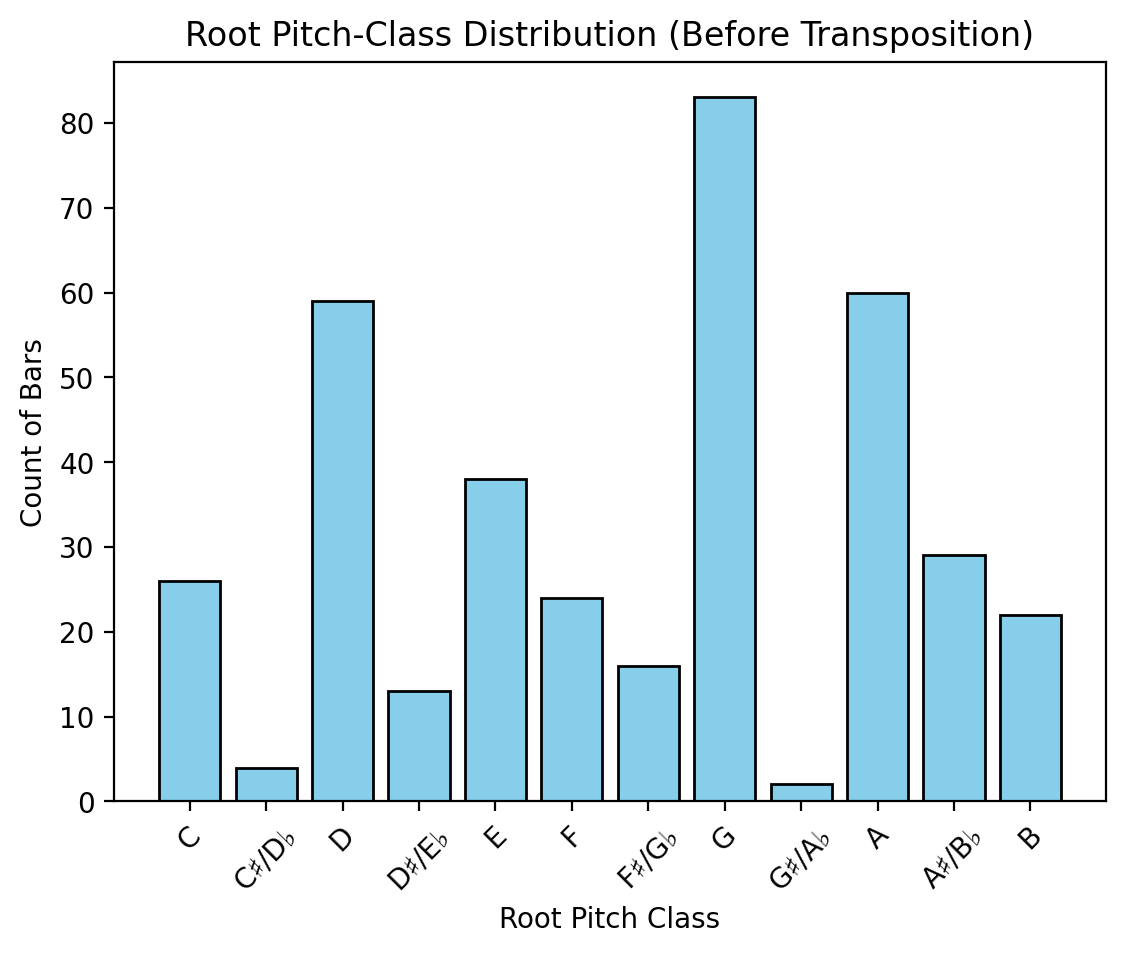

In [5]:
# 1) Extract bars & roots per chorale
def extract_measure_data(score_obj):
    MEASURE_LENGTH = 4.0
    if isinstance(score_obj, stream.Opus):
        seq = []
        for sub in score_obj:
            seq.extend(extract_measure_data(sub))
        return seq

    parts = score_obj.parts
    soprano_events = [ev for ev in parts[0].recurse()
                      .getElementsByClass((note.Note, chord.Chord))]
    bass_events = [ev for ev in parts[-1].recurse()
                   .getElementsByClass((note.Note, chord.Chord))]

    total_q = score_obj.highestTime
    n_bars = int(np.ceil(total_q / MEASURE_LENGTH))
    bar_data = []

    for i in range(n_bars):
        start_t, end_t = i*4.0, (i+1)*4.0
        hist = np.zeros(12, dtype=int)
        for ev in soprano_events:
            if start_t <= ev.offset < end_t:
                pc = ev.pitch.pitchClass if isinstance(ev, note.Note) \
                     else max(p.pitchClass for p in ev.pitches)
                hist[pc] += 1
        if hist.sum() == 0: continue

        cands = [ev for ev in bass_events if start_t <= ev.offset < end_t]
        if not cands: continue
        best_b = min(cands, key=lambda ev: abs(ev.offset - start_t))
        root_pc = best_b.pitch.pitchClass
        bar_data.append((tuple(hist), root_pc))

    return bar_data

chorale_bar_counts = []
root_counts = Counter()

for idx, score in enumerate(corpus.chorales.Iterator()):
    bars = extract_measure_data(score)
    n_bars = len(bars)
    if n_bars > 0:
        chorale_bar_counts.append({'chorale_id': idx+1, 'n_bars': n_bars})
        for _, root in bars:
            root_counts[root] += 1

# 4) Root distribution (before augmentation)
pc_names = ['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B']
root_df = pd.DataFrame({'root_pc': list(root_counts.keys()),
                        'count': list(root_counts.values())})
root_df['root_name'] = root_df['root_pc'].apply(lambda x: pc_names[x])
root_df = root_df.sort_values('root_pc')
print(root_df)

# 5) Plot root distribution
plt.bar(root_df['root_name'], root_df['count'], color='skyblue', edgecolor='black')
plt.title("Root Pitch-Class Distribution (Before Transposition)")
plt.xlabel("Root Pitch Class")
plt.ylabel("Count of Bars")
plt.xticks(rotation=45)
plt.show()

## Data Processing

In [4]:
# ── 2) EXTRACT (histogram → root) FROM ONE Score or Opus ─────────────────────────
def extract_measure_examples(obj):
    if isinstance(obj, stream.Opus):
        seq = []
        for sub in obj:
            try:
                seq.extend(extract_measure_examples(sub))
            except Exception:
                continue
        return seq

    score = obj
    parts = score.parts
    if len(parts) < 1:
        return []

    soprano_events = [
        ev for ev in parts[0].recurse().getElementsByClass((note.Note, chord.Chord))
    ]
    bass_events = [
        ev for ev in parts[-1].recurse().getElementsByClass((note.Note, chord.Chord))
    ]

    total_q = score.highestTime
    n_bars  = int(np.ceil(total_q / MEASURE_LENGTH))
    examples = []

    for i in range(n_bars):
        start_t = i * MEASURE_LENGTH
        end_t   = start_t + MEASURE_LENGTH

        # build a 12‐dim histogram over soprano_events in [start_t, end_t)
        hist = np.zeros(12, dtype=np.float32)
        for ev in soprano_events:
            if start_t <= ev.offset < end_t:
                if isinstance(ev, note.Note):
                    pc = ev.pitch.pitchClass
                else:  # chord.Chord
                    pc = max(p.pitchClass for p in ev.pitches)
                hist[pc] += 1.0
        if hist.sum() < 1e-6:
            # skip bars with no soprano events
            continue
        hist /= hist.sum()

        # find bass event closest to downbeat
        candidates = [ev for ev in bass_events if start_t <= ev.offset < end_t]
        if not candidates:
            continue
        best_bass = min(candidates, key=lambda ev: abs(ev.offset - start_t))
        root_pc   = best_bass.pitch.pitchClass

        examples.append((hist, root_pc))

    return examples


# ── 3) BUILD AUGMENTED DATASET FROM BACH CHORALES ─────────────────────────────────
def build_bach_chorale_examples_augmented():
    """
    Iterate through each chorale in music21.corpus.chorales.Iterator().
    For each Score:
      • For each transposition interval from 0 to 11 semitones:
          – Make a copy of the Score, transpose by that many semitones.
          – Extract (hist, root) pairs via extract_measure_examples().
          – Collect all pairs.
    Returns a flat list of (hist, root) across all transpositions of all chorales.
    """
    all_examples = []
    iterator = corpus.chorales.Iterator()

    g = 0
    for score in iterator:
        for semitone in range(12):
            try:
                transposed = score.transpose(semitone)
            except Exception:
                print('E')
                continue

            try:
                exs = extract_measure_examples(transposed)
            except Exception:
                print('E2')
                continue

            all_examples.extend(exs)
        if g % 10 == 0:
            print(f'done with score {g}')
        g += 1

    return all_examples


print("⏳ 1) Extracting & augmenting bars from all Bach chorales …")
all_data = build_bach_chorale_examples_augmented()
print(f"   → Total augmented bars: {len(all_data)}\n")

# Shuffle and split 80/20
random.shuffle(all_data)
split_idx = int((1 - VAL_RATIO) * len(all_data))
train_data = all_data[:split_idx]
val_data   = all_data[split_idx:]

print(f"Training bars:   {len(train_data)}")
print(f"Validation bars: {len(val_data)}\n")


# ── 4) TORCH DATASET FOR (hist, root) PAIRS ──────────────────────────────────────
class BarDataset(Dataset):
    def __init__(self, examples):
        self.hists = [torch.tensor(e[0], dtype=torch.float32) for e in examples]
        self.labs  = [torch.tensor(e[1], dtype=torch.long)   for e in examples]

    def __len__(self):
        return len(self.hists)

    def __getitem__(self, idx):
        return self.hists[idx], self.labs[idx]


train_ds = BarDataset(train_data)
val_ds   = BarDataset(val_data)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

## Model Training

In [253]:
class ContextualMLP(nn.Module):
    def __init__(self, input_dim=12, hidden1=32, hidden2=1024, hidden3=64, output_dim=12, dropout=0.08):
        super().__init__()
        # Layer 1
        self.fc1    = nn.Linear(input_dim, hidden1)
        self.bn1    = nn.BatchNorm1d(hidden1)
        self.drop1  = nn.Dropout(dropout)

        # Layer 2
        self.fc2    = nn.Linear(hidden1, hidden2)
        self.bn2    = nn.BatchNorm1d(hidden2)
        self.drop2  = nn.Dropout(dropout)

        # Layer 3
        self.fc3    = nn.Linear(hidden2, hidden3)
        self.bn3    = nn.BatchNorm1d(hidden3)
        self.drop3  = nn.Dropout(dropout)

        # Final classification
        self.fc4    = nn.Linear(hidden3, output_dim)

        # If we want a “residual” from fc1→fc3, we need to map hidden1→hidden3 if dims differ
        if hidden1 != hidden3:
            self.residual_mapper = nn.Linear(hidden1, hidden3)
        else:
            self.residual_mapper = None

    def forward(self, x):
        h1 = self.fc1(x)
        h1 = self.bn1(h1)
        h1 = F.relu(h1)
        h1 = self.drop1(h1)

        h2 = self.fc2(h1)
        h2 = self.bn2(h2)
        h2 = F.relu(h2)
        h2 = self.drop2(h2)

        h3 = self.fc3(h2
        h3 = self.bn3(h3)

        if self.residual_mapper is not None:
            res = self.residual_mapper(h1)
        else:
            res = h1

        h3 = F.relu(h3 + res)
        h3 = self.drop3(h3)

        logits = self.fc4(h3)
        return logits



model = ContextualMLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()


# ── 6) TRAIN & VALIDATE ─────────────────────────────────────────────────────────
best_val_loss = float("inf")
patience = 3
no_improve = 0

print("⏳ 2) Training MLP on augmented Bach chorale bars …")
for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model.train()
    train_loss = 0.0
    train_count = 0

    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_count += x.size(0)

    train_loss /= train_count

    # VALIDATE
    model.eval()
    val_loss = 0.0
    val_count = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            val_count += x.size(0)
    val_loss /= val_count

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), WEIGHTS_PATH)
        print("  → Saved new best weights.")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("  → Early stopping.\n")
            break

print(f"✅ Training complete. Best validation loss = {best_val_loss:.4f}\n")

⏳ 2) Training MLP on augmented Bach chorale bars …
Epoch 01 | Train Loss: 1.5396 | Val Loss: 1.1341
  → Saved new best weights.
Epoch 02 | Train Loss: 1.1815 | Val Loss: 1.0469
  → Saved new best weights.
Epoch 03 | Train Loss: 1.1230 | Val Loss: 1.0163
  → Saved new best weights.
Epoch 04 | Train Loss: 1.0797 | Val Loss: 1.0164
Epoch 05 | Train Loss: 1.0571 | Val Loss: 0.9907
  → Saved new best weights.
Epoch 06 | Train Loss: 1.0240 | Val Loss: 0.9817
  → Saved new best weights.
Epoch 07 | Train Loss: 1.0332 | Val Loss: 0.9912
Epoch 08 | Train Loss: 1.0043 | Val Loss: 0.9716
  → Saved new best weights.
Epoch 09 | Train Loss: 0.9855 | Val Loss: 0.9587
  → Saved new best weights.
Epoch 10 | Train Loss: 0.9803 | Val Loss: 0.9590
Epoch 11 | Train Loss: 0.9591 | Val Loss: 0.9444
  → Saved new best weights.
Epoch 12 | Train Loss: 0.9670 | Val Loss: 0.9270
  → Saved new best weights.
Epoch 13 | Train Loss: 0.9424 | Val Loss: 0.9377
Epoch 14 | Train Loss: 0.9408 | Val Loss: 0.9489
Epoch 15 | 

In [254]:
# ── 7) INFERENCE: ONE‐CHORD‐PER‐BAR FOR A LOCAL MIDI ─────────────────────────────
def harmonize(midi_path):
    """
    1) Load local MIDI via mido (polyphony OK).
    2) Extract monophonic soprano: highest note per tick.
    3) Split into fixed 4/4 bars by tick: build 12‐dim histogram per bar.
    4) Feed each histogram into trained MLP → root_pc.
    5) Overlay one major triad per bar under original tracks and save
       as <stem>_one_chord_bach_augmented.mid.
    """
    if not os.path.isfile(midi_path):
        print(f"Error: '{midi_path}' not found.")
        return

    mid = mido.MidiFile(midi_path)
    tpb = mid.ticks_per_beat
    ticks_per_bar = tpb * 4

    raw_events = []
    for tr in mid.tracks:
        abs_t = 0
        for msg in tr:
            abs_t += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                raw_events.append((abs_t, msg.note))
    if not raw_events:
        print("No note_on events found.")
        return

    by_tick = defaultdict(list)
    for t, n in raw_events:
        by_tick[t].append(n)
    sopr = [(t, max(ns)) for t, ns in by_tick.items()]

    max_tick = max(t for t, _ in sopr)
    n_bars = (max_tick // ticks_per_bar) + 1

    preds = []
    for i in range(n_bars):
        st = i * ticks_per_bar
        et = st + ticks_per_bar
        hist = np.zeros(12, dtype=np.float32)
        for t, n in sopr:
            if st <= t < et:
                hist[n % 12] += 1.0
        if hist.sum() < 1e-6:
            root_pc = 0
        else:
            hist /= hist.sum()
            ht = torch.tensor(hist, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                logits = model(ht)
                root_pc = torch.argmax(logits, dim=-1).item()
        preds.append(root_pc)

    chord_track = mido.MidiTrack()
    for root_pc in preds:
        base = 60 + (root_pc % 12)
        third = base + 4
        fifth = base + 7
        chord_track.append(mido.Message('note_on', channel=0, note=base, velocity=64, time=0))
        chord_track.append(mido.Message('note_on', channel=0, note=third, velocity=64, time=0))
        chord_track.append(mido.Message('note_on', channel=0, note=fifth, velocity=64, time=0))
        chord_track.append(mido.Message('note_off', channel=0, note=base, velocity=64, time=ticks_per_bar))
        chord_track.append(mido.Message('note_off', channel=0, note=third, velocity=64, time=0))
        chord_track.append(mido.Message('note_off', channel=0, note=fifth, velocity=64, time=0))

    chord_track.append(mido.MetaMessage('end_of_track', time=1))

    new_mid = mido.MidiFile()
    new_mid.ticks_per_beat = mid.ticks_per_beat
    for tr in mid.tracks:
        new_mid.tracks.append(tr.copy())
    new_mid.tracks.append(chord_track)

    stem = os.path.splitext(os.path.basename(midi_path))[0]
    out = f"{stem}_harmonized.mid"
    new_mid.save(out)
    print(f"Saved → {out}")

## Evaluation

Validation Accuracy:  74.20%


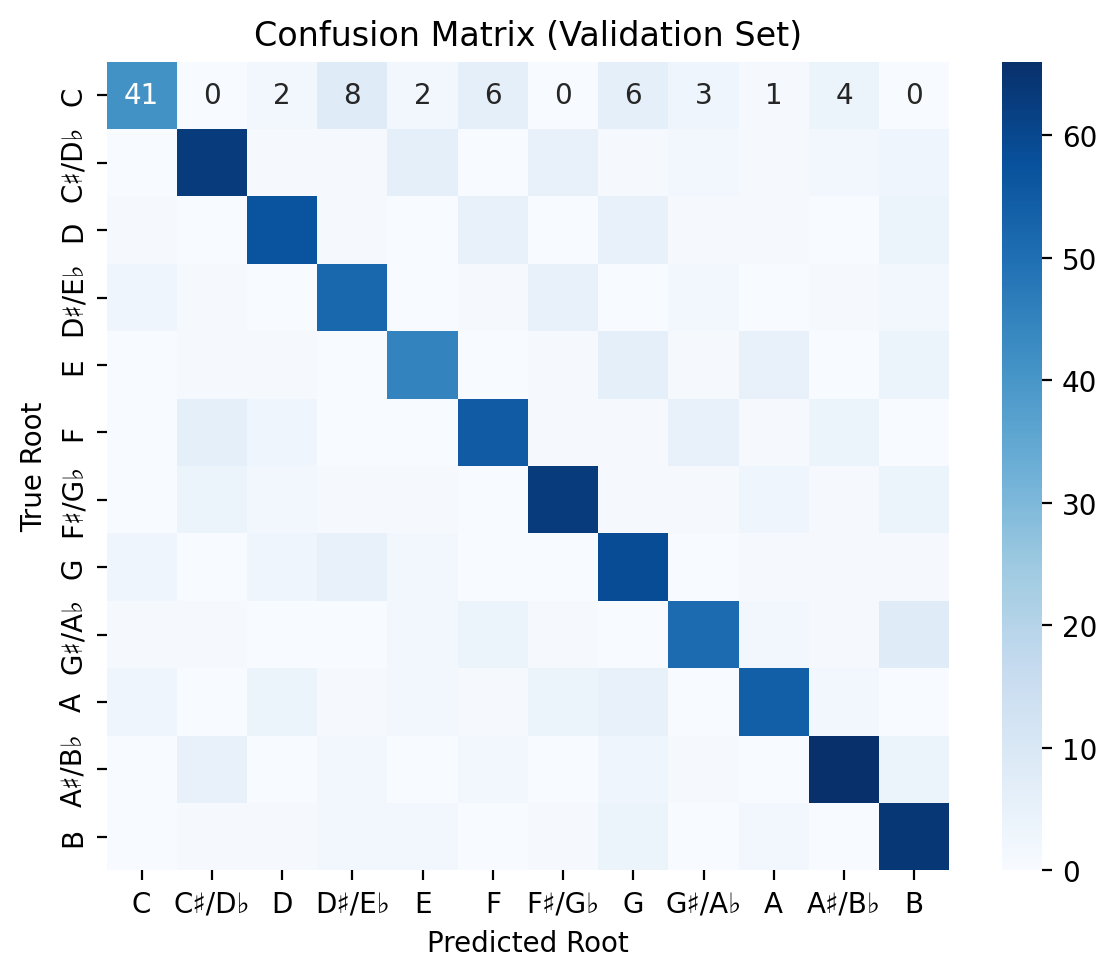

In [261]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score

# 1) Load trained model & validation DataLoader
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x = x_batch.to(DEVICE)
        y = y_batch.to(DEVICE)
        logits = model(x)
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y.cpu().numpy())

preds_array   = np.concatenate(all_preds)
targets_array = np.concatenate(all_targets)

# 2) Compute Overall Accuracy and Top-2 Accuracy
acc = accuracy_score(targets_array, preds_array)

print(f"Validation Accuracy:  {acc*100:.2f}%")

# 3) Confusion Matrix
cm = confusion_matrix(targets_array, preds_array, labels=list(range(12)))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B'],
            yticklabels=['C','C♯/D♭','D','D♯/E♭','E','F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B'])
plt.xlabel("Predicted Root")
plt.ylabel("True Root")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()


## Harmonizing And Testing Local Midi Files

In [6]:
print("\nEnter path to a local MIDI file to harmonize\n")
path = input("MIDI path: ").strip()
harmonize(path)

In [258]:
import pygame

pygame.init()
pygame.mixer.music.load("bach_846_harmonized.mid")
pygame.mixer.music.play()